In [14]:
import re
import pickle
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

nltk.download("stopwords", quiet=True)
stops = set(stopwords.words("indonesian") + stopwords.words("english"))

stemmer = nltk.stem.SnowballStemmer("english")

hoax = (
    pd.read_csv(
        "../Dataset/hoax_news.csv",
        usecols=["Title", "Narasi", "category"]
    )
    .dropna(subset=["Title", "Narasi", "category"])
)

# Rename and label
hoax.rename(columns={"Title": "title", "Narasi": "body"}, inplace=True)
hoax["label"] = "hoax"

real = pd.read_csv(
    "../Dataset/detik_news.csv",
    usecols=["page", "title", "url", "content"]
).dropna(subset=["title", "content"])

# Keep only true hoaxes, rename columns, label them
hoax = hoax[~hoax["category"].isin(["Benar", "Disinformasi"])].copy()
hoax.rename(columns={"Title": "title", "Narasi": "body"}, inplace=True)
hoax["label"] = "hoax"

# For real news, just rename and label
real.rename(columns={"content": "body"}, inplace=True)
real["label"] = "real"
real = real[["title", "body", "label"]]

# Remove outliers in the hoax set based on title/body length
hoax["title_len"] = hoax["title"].str.len()
hoax["body_len"]  = hoax["body"].str.len()

for length_col in ["title_len", "body_len"]:
    q1 = hoax[length_col].quantile(0.25)
    q3 = hoax[length_col].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    hoax = hoax[(hoax[length_col] >= lower) & (hoax[length_col] <= upper)]

hoax.drop(columns=["title_len", "body_len", "category"], inplace=True)

# Balance the two classes by down-sampling to the smaller class size
df = pd.concat([hoax, real], ignore_index=True)
min_count = df["label"].value_counts().min()
df = (
    df.groupby("label", group_keys=False)
      .apply(lambda grp: grp.sample(min_count, random_state=42))
      .reset_index(drop=True)
)

# Split into train / validation / test (70% / 20% / 10%)
X = df[["title", "body"]].astype(str)
y = df["label"]

#  Hold out 10% for final test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

#  From the remaining 90%, take 20% for validation (i.e. 0.2/0.9 of original)
val_frac = 0.2 / 0.9
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_frac, stratify=y_temp, random_state=42
)

# Define cleaning + tokenizing + stemming function
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = [t for t in text.split() if t not in stops and len(t) > 1]
    return [stemmer.stem(t) for t in tokens]

# Apply to each split, concatenating title + body
for split in [X_train, X_val, X_test]:
    split["text"] = (
        split["title"].apply(clean_tokenize).apply(" ".join)
        + " "
        + split["body"].apply(clean_tokenize).apply(" ".join)
    )

# Turn text into bag-of-words vectors
vectorizer = CountVectorizer(max_features=1000)
X_train_bow = vectorizer.fit_transform(X_train["text"])
X_val_bow   = vectorizer.transform(X_val["text"])
X_test_bow  = vectorizer.transform(X_test["text"])

# Augment training data by randomly masking 40% of features
mask_prob   = 0.40
rng         = np.random.default_rng(42)
X_arr       = X_train_bow.toarray()
mask        = rng.binomial(1, 1 - mask_prob, size=X_arr.shape)
X_aug       = X_arr * mask

X_train_final = np.vstack([X_arr, X_aug])
y_train_final = np.hstack([y_train.values, y_train.values])

# Train a Decision Tree on the augmented data
print("Training...")
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_final, y_train_final)

# Evaluate on validation and test sets
for name, X_feat, y_true in [
    ("Validation", X_val_bow.toarray(), y_val),
    ("Test",       X_test_bow.toarray(),  y_test)
]:
    preds = dt.predict(X_feat)
    print(f"=== {name} Results ===")
    print("Accuracy:", accuracy_score(y_true, preds))
    print(classification_report(y_true, preds, digits=3))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, preds, labels=["hoax", "real"]))
    print()

#  Persist the trained pipeline for later use
with open("dt_bow_aug_hoax.pkl", "wb") as f:
    pickle.dump({
        "model":       dt,
        "vectorizer":  vectorizer,
        "stopwords":   stops,
        "mask_prob":   mask_prob,
        "stemmer":     stemmer
    }, f)

print("Pipeline saved to dt_bow_aug_hoax.pkl")


Training...
=== Validation Results ===
Accuracy: 0.962480458572173
              precision    recall  f1-score   support

        hoax      0.984     0.941     0.962       959
        real      0.943     0.984     0.963       960

    accuracy                          0.962      1919
   macro avg      0.963     0.962     0.962      1919
weighted avg      0.963     0.962     0.962      1919

Confusion Matrix:
[[902  57]
 [ 15 945]]

=== Test Results ===
Accuracy: 0.9478623566214807
              precision    recall  f1-score   support

        hoax      0.961     0.933     0.947       480
        real      0.935     0.962     0.949       479

    accuracy                          0.948       959
   macro avg      0.948     0.948     0.948       959
weighted avg      0.948     0.948     0.948       959

Confusion Matrix:
[[448  32]
 [ 18 461]]

Pipeline saved to dt_bow_aug_hoax.pkl


=== In-Distribution (Synthetic) Results ===
Accuracy: 0.48
              precision    recall  f1-score   support

        hoax      0.508     0.812     0.625        80
        real      0.318     0.100     0.152        70

    accuracy                          0.480       150
   macro avg      0.413     0.456     0.389       150
weighted avg      0.419     0.480     0.404       150



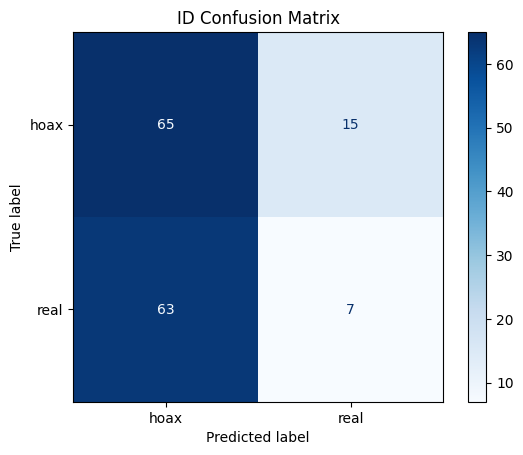

In [ ]:
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    ConfusionMatrixDisplay
)

# Load the saved pipeline
with open("dt_bow_aug_hoax.pkl", "rb") as f:
    data       = pickle.load(f)
    dt_model   = data["model"]
    vectorizer = data["vectorizer"]
    stops      = data["stopwords"]

# Re-use same clean/tokenize logic
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if t not in stops and len(t) > 1]
    return tokens

# Load your out-distribution synthetic test set
titles, bodies, true_labels = [], [], []
with open("../Dataset/synthetic_news.txt", "r", encoding="utf-8") as f:
    for line in f:
        t, b, lab = line.strip().split("\t")
        titles.append(t)
        bodies.append(b)
        true_labels.append(lab)

# Build feature matrix for synthetic
texts = [
    " ".join(clean_tokenize(t) + clean_tokenize(b)) 
    for t, b in zip(titles, bodies)
]
X_syn = vectorizer.transform(texts).toarray()

# Evaluate on synthetic (out of distribution)
preds_syn = dt_model.predict(X_syn)
print("=== In-Distribution (Synthetic) Results ===")
print("Accuracy:", accuracy_score(true_labels, preds_syn))
print(classification_report(true_labels, preds_syn, digits=3))
cm_syn = confusion_matrix(true_labels, preds_syn, labels=["hoax", "real"])
disp = ConfusionMatrixDisplay(cm_syn, display_labels=["hoax", "real"])
disp.plot(cmap="Blues")
plt.title("ID Confusion Matrix")
plt.show()